In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from os.path import isfile, join
from os import listdir
import pandas as pd
import random
import skimage
import imutils
from PIL import Image, ImageFilter 
from IPython.display import clear_output
from scipy import signal
from scipy import misc


In [3]:
%run ./variables.ipynb

DATASET_PATH_ROOT = "../../../../nvme-storage"
DATASET_PATH_REGION = "/RA/tmp"
#path = "../../../../nvme-storage/RA/tmp/RA_AAMB_6464.png"
#img = cv2.imread(path,cv2.COLOR_BGR2GRAY)

In [4]:
def rot_image(path):
    img = cv2.imread(path,cv2.COLOR_BGR2GRAY)
    #mask = np.zeros_like(img)-1
    
    #rotation mask et image
    mask_rot = np.ones(img.shape,np.uint8)
    angle = random.randint(0,90)
    img_rot = imutils.rotate_bound(img, angle)
    mask_rot = imutils.rotate_bound(mask_rot, angle)
    
    #erosion mask
    mask_erod =np.zeros_like(img_rot,np.uint8)
    kernel_size = 5
    kernel = np.ones((kernel_size,kernel_size),np.uint8)
    mask_erod = cv2.erode(mask_rot,kernel,iterations = 1)
    
    #bounding box
    bb1 = (np.asmatrix(np.where(mask_rot==1))[0,0],np.asmatrix(np.where(mask_rot==1))[1,0])
    bb2 = (np.asmatrix(np.where(mask_rot==1))[0,-1],np.asmatrix(np.where(mask_rot==1))[1,-1])
    
    #pixels erodé
    erod = (mask_rot - mask_erod)*255
    
    #erod_img[erod==255] = img_rot[erod==255]

    fond_moyen = []
    fond_moyen = img_rot[erod!=0]
    fond_moyen = int(np.mean(fond_moyen))
    img_rot[mask_erod == 0] = fond_moyen
    #display(Image.fromarray(img_rot))


    return(img_rot, mask_rot, mask_erod, fond_moyen)

In [5]:
def ImTranslate(h,tau):
    M, N = h.shape
    v = np.zeros((M,N))
    indrow = ((tau[0]+np.arange(M))%M).reshape(M,1)
    indcol = ((tau[1]+np.arange(N))%N).reshape(1,N)
    v[indrow,indcol] = h
    return v

def spot(img_rot,moyenne, b = 100, tau = [300,53] ,n=100):
    N2 = max(img_rot.shape)
    t = np.linspace(-b,b,N2).reshape(N2,1)
    i = np.random.randint(2)
    
    if i == 0:
        
        H1 = np.exp(-t**2-(t.T)**2)
        M, N = H1.shape
        u = np.zeros((M,N))
        
    if i == 1:
    
        H1 = b - np.exp(-t**2-(t.T)**2)
        M, N = H1.shape
        u = np.ones((M,N))

    v = ImTranslate(H1,[300,53])
    for k in range(n):
        tau0 = np.random.randint(M)
        tau1 = np.random.randint(N)
        u += ImTranslate(H1,[tau0,tau1])

    fond = np.zeros_like(img_rot)
    fond1 = u[0:fond.shape[0],0:fond.shape[1]]
    Fond11 = (fond1*moyenne/4+img_rot)-np.min(fond1*moyenne/4+img_rot)
    img_spot = ((Fond11/np.max(Fond11))*255).astype('int')
    return img_spot
    

In [6]:
def flou_cercle( img_rot, center, radius, alpha=10 ):
    #img = cv2.imread(path,cv2.COLOR_BGR2GRAY)
    h, w = img_rot.shape

    # Define mask 
    mask = 255*np.ones(img_rot.shape, dtype='uint8') 

    # Draw circle at x = int(w/2), y = int(h/2) of radius 25 and fill this in with 0 
    mask = cv2.circle(mask, (center), radius, color = 0, thickness = -1)  

    # Apply distance transform to mask 
    out = cv2.distanceTransform(mask, cv2.DIST_L2, 3) 

    # Define scale factor 
    scale_factor = alpha

    # Create output image that is the same as the original 
    filtered = img_rot.copy() 

    # Create floating point copy for precision 
    img_float = img_rot.copy().astype('float') 


    # For each pixel in the input... 
    for y in range(h): 
        for x in range(w): 

    # If distance transform is 0, skip 
            if out[y,x] == 0.0:
                continue 

            # Calculate M = d/S 
            mask_val = np.ceil(out[y,x]/scale_factor) 

        # If M is too small, set the mask size to the smallest possible value 
            if mask_val <= 3:
                mask_val = 3 

            # Get beginning and ending x and y coordinates for neighbourhood 
            # and ensure they are within bounds 
            beginx = x-int(mask_val/2) 
            if beginx < 0: 
                beginx = 0 

            beginy = y-int(mask_val/2) 
            if beginy < 0: 
                beginy = 0 

            endx = x+int(mask_val/2) 
            if endx >= w: 
                endx= w-1 

            endy = y+int(mask_val/2) 
            if endy >= h: 
                endy = h-1 

            # Get the coordinates of where we need to grab pixels 
            xvals = np.arange(beginx, endx+1) 
            yvals = np.arange(beginy, endy+1) 
            (col_neigh,row_neigh) = np.meshgrid(xvals, yvals) 
            col_neigh = col_neigh.astype('int') 
            row_neigh = row_neigh.astype('int') 

        # Get the pixels now 
        # For each channel, do the foveation 
            pix = img_float[row_neigh, col_neigh].ravel() 

     # Calculate the average and set it to be the output 
            filtered[y,x] = int(np.mean(pix)) 
        
        filtered = filtered[:,:] 
    #out2=out.astype(int)
    # Show the image 
    #display(Image.fromarray( filtered) )
    #display(Image.fromarray( mask) )
    #display(Image.fromarray( out2) )


    return(filtered)

In [17]:


def data_augment(DATASET_PATH_ROOT,DATASET_PATH_REGION,n):
    DATASET_PATH = join(DATASET_PATH_ROOT + DATASET_PATH_REGION)
    images = [f for f in listdir(DATASET_PATH) if isfile(join(DATASET_PATH , f))]
    
    path_BR_M = join(DATASET_PATH_ROOT + '/BR_M/tmp/' )
    images_BR_M = [f for f in listdir(path_BR_M) if isfile(join(path_BR_M , f))]
    init = images_BR_M[-1].split('_')[1]
    init = int(init.split('.')[0])
    
    for i in range(init+1, n+init+1):
        file = random.choice(images)
        path = join(DATASET_PATH_ROOT + DATASET_PATH_REGION + '/' + file)
        img_rot, mask_rot, mask_erod, fond_moyen = rot_image(path)
        h,w = img_rot.shape
        radius = random.randint(0,int(min(h,w)/2))
        alpha = random.randint(10,15)
        filtered  = flou_cercle(img_rot, center = (np.random.randint(w),np.random.randint(h)), radius=radius ,alpha=alpha)
        print(filtered.shape)
        img_final = spot(filtered,moyenne = fond_moyen, b = 20, tau = [300,53],n=200)
        file_image = join(DATASET_PATH_ROOT + "/BR_M/tmp/" + file.split('_')[1] + "_" + str(i) + ".png")
        cv2.imwrite(file_image,img_final)
        #plt.imshow(img_final)


(95, 233)
(241, 220)
(131, 53)
(241, 200)
(262, 240)
(132, 214)
(354, 225)


ValueError: too many values to unpack (expected 2)

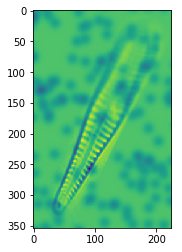

In [16]:
data_augment(DATASET_PATH_ROOT=DATASET_PATH_ROOT,DATASET_PATH_REGION=DATASET_PATH_REGION,n=10)

In [1]:
n=10
DATASET_PATH = join(DATASET_PATH_ROOT + DATASET_PATH_REGION)
images = [f for f in listdir(DATASET_PATH) if isfile(join(DATASET_PATH , f))]

path_BR_M = join(DATASET_PATH_ROOT + '/BR_M/tmp/' )
images_BR_M = [f for f in listdir(path_BR_M) if isfile(join(path_BR_M , f))]
init = images_BR_M[-1].split('_')[1]
init = int(init.split('.')[0])

for i in range(init+1, n+init+1):
    file = random.choice(images)
    path = join(DATASET_PATH_ROOT + DATASET_PATH_REGION + '/' + file)
    img_rot, mask_rot, mask_erod, fond_moyen = rot_image(path)
    h,w = img_rot.shape
    radius = random.randint(0,int(min(h,w)/2))
    alpha = random.randint(10,15)
    filtered  = flou_cercle(img_rot, center = (np.random.randint(w),np.random.randint(h)), radius=radius ,alpha=alpha)
    print(filtered.shape)
    img_final = spot(filtered,moyenne = fond_moyen, b = 100, tau = [300,53],n=200)
    file_image = join(DATASET_PATH_ROOT + "/BR_M/tmp/" + file.split('_')[1] + "_" + str(i) + ".png")
    cv2.imwrite(file_image,img_final)

NameError: name 'join' is not defined

In [26]:
h,w = img_rot.shape
h

240

In [10]:
DATASET_PATH
images = [f for f in listdir(DATASET_PATH) if isfile(join(DATASET_PATH , f))]
images

['RA_HCAP_2177.png',
 'RA_PPSC_8813.png',
 'RA_NSPD_0658.png',
 'RA_NCOM_2946.png',
 'RA_CDUB_6559.png',
 'RA_CCOC_1627.png',
 'RA_NHAN_3230.png',
 'RA_NIAR_2856.png',
 'RA_NFON_3118.png',
 'RA_NSOC_3544.png',
 'RA_TDEB_3822.png',
 'RA_NFIL_3068.png',
 'RA_SSUE_4086.png',
 'RA_CCOS_6609.png',
 'RA_CAPR_4241.png',
 'RA_NCOM_2948.png',
 'RA_GOLD_5710.png',
 'RA_PHEL_8031.png',
 'RA_ECTG_9039.png',
 'RA_PTCO_7939.png',
 'RA_COPL_7687.png',
 'RA_CPSE_1630.png',
 'RA_CTGL_4511.png',
 'RA_PPSC_8807.png',
 'RA_DTEN_2567.png',
 'RA_GCLF_5232.png',
 'RA_GOMS_6238.png',
 'RA_PAPR_2522.png',
 'RA_GVST_6145.png',
 'RA_GAGU_5145.png',
 'RA_GLGN_5494_A.png',
 'RA_EULA_7720.png',
 'RA_APED_4203.png',
 'RA_SLAC_4021.png',
 'RA_NRCH_0822.png',
 'RA_SANG_3958.png',
 'RA_AUGR_6484.png',
 'RA_NCTV_0071.png',
 'RA_CSUT_4467.png',
 'RA_LGOE_2246.png',
 'RA_DDEL_4662.png',
 'RA_DMON_6953.png',
 'RA_FNEV_8511.png',
 'RA_DMON_7034.png',
 'RA_FVUC_2071.png',
 'RA_CBAM_4570.png',
 'RA_FAPP_2056.png',
 'RA_GRHB_6